# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr
4. Find something for JM to do

In [8]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, get_file_number, local_earthquake_quicklook
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import plot_trigger
import scipy
from scipy.fft import fft, ifft

### Get a list of events from USGS

In [ ]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime.now(),
                maxradiuskm=50, 
                latitude=47.60, 
                longitude=-122.33)

print("Returned %s events" % len(events))

In [ ]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['magnitude'],ascending=False)
event_df.iloc[0:5]

### Choose an event to analyze

In [ ]:
detected_quakes = ['uw61869652','uw61860022','uw61847792',
                   'uw61846087','uw61834816']
# detected_quakes_whidbey = ['uw61832097','uw61819867','uw61855012','us7000gxl1']

# this_event_index = 0
# this_id=detected_quakes[this_event_index]

this_id = 'uw61846087'

this_event = event_df[event_df.id==this_id]
t0 = this_event['time'].iloc[0]

this_event

### Load the DAS Data

In [ ]:
# cable = 'seadasn'
cable = 'seadasn'
record_length = 10 #minutes

if cable == 'seadasn':
    prefix = 'seadasn'
    network_name = 'SeaDAS-N'
    if t0 < datetime.datetime(2022, 6, 20, 0, 0, 0):
        datastore='/data/data0/seadasn_2022-03-17_2022-06-20/'
    else:
        datastore='/data/data7/seadasn_2022-06-21_2022-10-06/'
        
elif cable == 'whidbey':
    prefix = 'whidbey'
    network_name='Whidbey-DAS'
    datastore = '/data/data5/Converted/'

data,dates,attrs = open_sintela_file(prefix,
                                     t0,
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=True)
x_max=data.shape[1] * attrs['SpatialSamplingInterval']

In [ ]:
low_cut = 2
hi_cut = 10

b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
data_filt = filtfilt(b,a,data,axis=0)

In [ ]:
client = Client("IRIS")

t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
dt = datetime.timedelta(minutes=record_length)
t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
# st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
st2 = client.get_waveforms("IU", "COR", "00", "HH1", t1, t2, attach_response=True)

pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
st.remove_response(output='VEL', pre_filt=pre_filt)
st2.remove_response(output='VEL', pre_filt=pre_filt)

In [ ]:
# nombre = f"figures/{event_df.iloc[catalog_index]['Evid']}.png"
# local_earthquake_quicklook(dates,data_filt,st,st2,x_max,event_df,catalog_index,filename=nombre)


stitle=f"M {this_event['magnitude'].to_numpy()[0]}, "\
       f"{this_event['location'].to_numpy()[0]}, "\
       f"{str(this_event['time'].to_numpy()[0])[0:-10]} UTC"


local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
                           stitle,das_vmax=0.02,
                           network_name=network_name)

In [ ]:
this_event.url.to_list()[0]

In [ ]:
# from tqdm import tqdm
# xc = np.zeros((2*18000-1,174))

# for i in tqdm(range(174)):
#     xc[:,i] = np.correlate(np.sign(data_filt[:,30]),
#                            np.sign(data_filt[:,i*10]),
#                            mode='full')

In [ ]:
fig,ax=plt.subplots()
plt.imshow(xc.T,aspect='auto',vmin=-1000,vmax=1000)
# plt.plot(data_filt[:,30])
# plt.plot(data_filt[:,40])
plt.xlim(18000-1e3,18000+1e3)
plt.show()

In [ ]:
fig,ax=plt.subplots()
# plt.imshow(xc.T,aspect='auto',vmin=-0.1,vmax=0.1)
plt.plot(data_filt[:,30:40], alpha=0.3)
plt.plot(data_filt[:,30],alpha=0.5)
#plt.xlim(7050,7200)
plt.ylim(-0.5,0.5)
plt.show()

In [ ]:
fig,ax=plt.subplots()

for i in data_filt.T[30:100]:
    ax.plot(i, c='grey', alpha=0.1)
plt.xlim([6800,12000])
plt.ylim([-1,1])
plt.show()

In [ ]:
import scipy
from scipy.fft import fft, ifft
af = fft(data_filt[:,30])
bf = fft(data_filt[:,40])
c = ifft(af * scipy.conj(bf))

time_shift = np.argmax(c)
print(time_shift)

In [ ]:
import obspy.core.trace 
das_trace = obspy.core.trace.Trace(data_filt[:,40])
das_trace.plot()

In [ ]:
das_trace.stats['sampling_rate'] = 100.0

In [ ]:
das_trace.stats.sampling_rate

In [ ]:
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import plot_trigger

df = das_trace.stats.sampling_rate
cft = classic_sta_lta(das_trace, int(6* df), int(10 * df))

plot_trigger(das_trace, cft, 1.5, 0.5)

In [ ]:
#print(cft.argmax())

In [ ]:
channel_picks = []
chan_number = 0

for channel in data_filt.T:
    das_trace = obspy.core.trace.Trace(channel)
    das_trace.stats['sampling_rate'] = 100.0
    df = das_trace.stats.sampling_rate
    cft = classic_sta_lta(das_trace, int(5 * df), int(10 * df))
    
    channel_picks.append( cft.argmax() / 100 )
    
    chan_number +=1

In [ ]:
plt.plot(channel_picks)
#plt.ylim([7000,8000])
plt.ylabel('Time (s)')
plt.xlabel('Channel Number')

In [ ]:
local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
                           stitle,das_vmax=0.02,
                           network_name=network_name)

# Routine for picking wave arrival times from lcoal events

In [36]:
#Function that returns the DAS data according to USGS earthquake events

def das_downloader(this_id, cab='seadasn'):
    this_event = event_df[event_df.id==this_id]
    t0 = this_event['time'].iloc[0]

    cable = cab
    record_length = 5 #minutes
    
    try:
        if cable == 'seadasn':
            prefix = 'seadasn'
            network_name = 'SeaDAS-N'
            if t0 < datetime.datetime(2022, 6, 20, 0, 0, 0):
                datastore='/data/data0/seadasn_2022-03-17_2022-06-20/'
            elif t0 > datetime.datetime(2022, 6, 20, 0, 0, 0) and t0 < datetime.datetime(2022, 10, 6, 0, 0, 0):
                datastore='/data/data7/seadasn_2022-06-21_2022-10-06/'
            elif t0 > datetime.datetime(2022, 11, 1, 0, 0, 0) and t0 < datetime.datetime(2022, 11, 5, 0, 0, 0):
                datastore='/data/data4/seadasn_2021-11-01_2021-11-05/'
            elif t0 > datetime.datetime(2022, 10, 13, 0, 0, 0) and t0 < datetime.datetime(2022, 11, 1, 0, 0, 0):
                datastore='/data/data1/seadasn_2021-10-13_2021-11-01/'

        elif cable == 'whidbey':
            prefix = 'whidbey'
            network_name='Whidbey-DAS'
            datastore = '/data/data5/Converted/'

        data,dates,attrs = open_sintela_file(prefix,
                                             t0,
                                             datastore,
                                             number_of_files=record_length,
                                             verbose=True)
        x_max=data.shape[1] * attrs['SpatialSamplingInterval']
        
        low_cut = 2
        hi_cut = 10

        b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
        data_filt = filtfilt(b,a,data,axis=0)
    
    except:
        print('No data for this quake!')
        data = None
        dates = None
        attrs = None
        x_max = None
        data_filt = None
    return data, dates, attrs, x_max, this_id, data_filt, t0

In [37]:

#Load events (specify search radius)
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime.now(),
                maxradiuskm=30, 
                latitude=47.60, 
                longitude=-122.33)

print("Returned %s events" % len(events))

#Get list of USGS events
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['magnitude'],ascending=False)

#Create a list with the event id numbers for data download
earthquake_list = event_df['id'].values.tolist()

Returned 57 events


In [72]:
arrival_picks = {}
das_quake_attrs = {}

for i in earthquake_list[:1]:
    
    data, dates, attrs, x_max, this_id, data_filt, t0 = das_downloader(i)
    
    if attrs != None:
        
        print(attrs['NumberOfLoci'])
        
    das_quake_attrs[this_id] = attrs
    if  x_max != None:
        channel_picks = []
        chan_number = 0
        for channel in data_filt.T:           
            das_trace = obspy.core.trace.Trace(channel)
            das_trace.stats['sampling_rate'] = 100.0
            df = das_trace.stats.sampling_rate
            cft = classic_sta_lta(das_trace, int(0.5 * df), int(20 * df))

            channel_picks.append( (cft.argmax() / attrs['PulseRate'] - (t0 - dates[0] ).total_seconds() ))#divide ny pulse rate to account for  unit change to seconds 

            chan_number +=1
    
    arrival_picks[str(i)] = channel_picks
    

/data/data7/seadasn_2022-06-21_2022-10-06/seadasn_2022-06-25_13-08*.h5
/data/data7/seadasn_2022-06-21_2022-10-06/seadasn_2022-06-25_13-09*.h5
/data/data7/seadasn_2022-06-21_2022-10-06/seadasn_2022-06-25_13-10*.h5
/data/data7/seadasn_2022-06-21_2022-10-06/seadasn_2022-06-25_13-11*.h5
/data/data7/seadasn_2022-06-21_2022-10-06/seadasn_2022-06-25_13-12*.h5
1750


In [73]:
for i in arrival_picks:
    print(i)

uw61846087


In [74]:
arrival_times_1749 = []

for i in arrival_picks:
    if len(arrival_picks[i]) == 1749:
        #print(i)
        arrival_times_1749.append(arrival_picks[i])

In [75]:
arrival_times_1749 = np.asarray(arrival_times_1749)

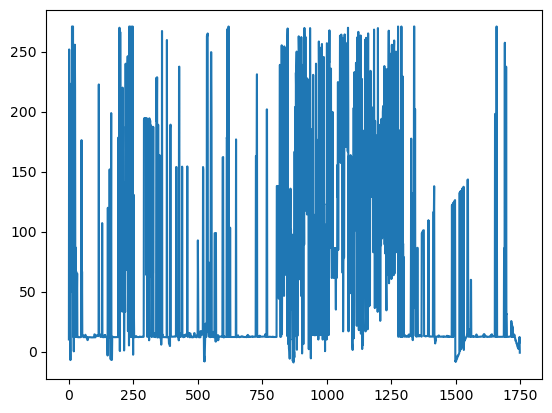

In [76]:
plt.plot(arrival_times_1749.T)
plt.show()
#plt.colorbar(label = 'Arrival Time (s)')

In [ ]:
#Load the fiber location and calibration data
fiber_location = pd.read_csv('fiberroute.csv', header=1)
fiber_calibration = pd.read_csv('calibration.csv', header=1)

import geopy.distance
fiber_distance = []

for index, row in fiber_location.iterrows():
    if index == 0 :
        fiber_distance.append(0)
    elif index <= len(fiber_location.index) -1:
        coords_1 = (row['Lat'], row['Long'])
        coords_2 = (fiber_location.iloc[index-1]['Lat'], fiber_location.iloc[index-1]['Long'])
        distance = geopy.distance.geodesic(coords_1, coords_2).m
        fiber_distance.append(distance   + fiber_distance[-1])
        
fiber_location['Fiber Dist'] = fiber_distance

#Plot
fig, ax = plt.subplots(figsize = (8,7))
ax.plot(fiber_location['Long'], fiber_location['Lat'], zorder=1, alpha= 0.2, c='b')
ax.plot(fiber_calibration['Long'], fiber_calibration['Lat'], zorder=1, alpha= 0.2, c='g')

In [ ]:
#Calculate the fiber distance between points in the fiber location file
import geopy.distance
fiber_distance = []

for index, row in fiber_location.iterrows():
    if index == 0 :
        fiber_distance.append(0)
    elif index <= len(fiber_location.index) -1:
        coords_1 = (row['Lat'], row['Long'])
        coords_2 = (fiber_location.iloc[index-1]['Lat'], fiber_location.iloc[index-1]['Long'])
        distance = geopy.distance.geodesic(coords_1, coords_2).m
        fiber_distance.append(distance   + fiber_distance[-1])
        
fiber_location['Fiber Dist'] = fiber_distance

In [ ]:
fiber_location

In [ ]:
fiber_calibration

In [ ]:
opt_dis_merge = []

for index_fib, row_fib in fiber_location.iterrows():
    l = []
    for index_cal, row_cal in fiber_calibration.iterrows():
        if row_fib['Lat'] == row_cal['Lat'] and row_fib['Long'] == row_cal['Long']:
            l.append(row_cal['Opt Dist'])
        else:
            pass
    if l:
        opt_dis_merge.append(l[0])
    else:
        opt_dis_merge.append(np.nan)

In [ ]:
fiber_location['Opt Dist'] = opt_dis_merge
dis_interp = fiber_location['Opt Dist'].interpolate(method='linear', fill_value='extrapolate')
fiber_location['Opt Dist Interp'] = dis_interp

fiber_location

### Routine for interpolating the channel location based off the calibration file.

In [ ]:
import geopy.distance

#For sintela fiberroute and calibration files
def fiber_channel_locator(fiber_file = 'fiberroute.csv', cal_file='calibration.csv', chan_spac = 1749):

    fiber_location = pd.read_csv(fiber_file, header=1)
    fiber_calibration = pd.read_csv(cal_file, header=1)
    fiber_distance = []

    for index, row in fiber_location.iterrows():
        if index == 0 :
            fiber_distance.append(0)
        elif index <= len(fiber_location.index) -1:
            coords_1 = (row['Lat'], row['Long'])
            coords_2 = (fiber_location.iloc[index-1]['Lat'], fiber_location.iloc[index-1]['Long'])
            distance = geopy.distance.geodesic(coords_1, coords_2).m
            fiber_distance.append(distance   + fiber_distance[-1])

    fiber_location['Fiber Dist'] = fiber_distance

# Widbey Island Work - 
## Plotting the fiber location and interpolated optical distance

In [ ]:
#Load the fiber location and calibration data
fiber_location_w = pd.read_csv('fiberroute_whidbey.csv', header=1)
fiber_calibration_w = pd.read_csv('calibration_whidbey.csv', header=1)

#Plot
fig, ax = plt.subplots(figsize = (8,7))
ax.plot(fiber_location_w['Long'], fiber_location_w['Lat'], zorder=1, alpha= 0.2, c='b')
ax.plot(fiber_calibration_w['Long'], fiber_calibration_w['Lat'], zorder=1, alpha= 0.2, c='g')

In [ ]:
import geopy.distance
fiber_distance_w = []

for index, row in fiber_location_w.iterrows():
    if index == 0 :
        fiber_distance_w.append(0)
    elif index <= len(fiber_location_w.index) -1:
        coords_1 = (row['Lat'], row['Long'])
        coords_2 = (fiber_location_w.iloc[index-1]['Lat'], fiber_location_w.iloc[index-1]['Long'])
        distance = geopy.distance.geodesic(coords_1, coords_2).m
        fiber_distance_w.append(distance  + fiber_distance_w[-1])
        
fiber_location_w['Fiber Dist'] = fiber_distance_w

In [ ]:
opt_dis_merge_w = []

for index_fib, row_fib in fiber_location_w.iterrows():
    l = []
    for index_cal, row_cal in fiber_calibration.iterrows():
        if row_fib['Lat'] == row_cal['Lat'] and row_fib['Long'] == row_cal['Long']:
            l.append(row_cal['Opt Dist'])
        else:
            pass
    if l:
        opt_dis_merge_w.append(l[0])
    else:
        opt_dis_merge_w.append(np.nan)

In [ ]:
fiber_location_w['Opt Dist'] = opt_dis_merge_w
dis_interp_w = fiber_location_w['Opt Dist'].interpolate(method='linear', fill_value='extrapolate')
fiber_location_w['Opt Dist Interp'] = dis_interp_w

fiber_location_w

# Constructing the G matrix (distances)

In [ ]:
import geopy.distance
import pandas as pd
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
from dasquakes import sintela_to_datetime, open_sintela_file, get_file_number, local_earthquake_quicklook
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

G =[]

fiber_location = pd.read_csv('fiberroute.csv', header=1)
fiber_calibration = pd.read_csv('calibration.csv', header=1)

events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime.now(),
                maxradiuskm=50, 
                latitude=47.60, 
                longitude=-122.33)

event_df = get_summary_data_frame(events)

for i in event_df.iloc:
    for j in fiber_location.iloc:
        coords_1 = (i['latitude'], i['longitude']) #earthquake origin coordinates
        coords_2 = (j['Lat'], j['Long'])
        distance = geopy.distance.geodesic(coords_1, coords_2).m
        G.append(distance)
        
G = np.asarray(G)
G = np.reshape(G, (len(event_df), len(fiber_location)))
print(G)